# Expectation Maximization (EM) for Gaussian Mixture Models (GMMs)

EM algorithm fits a GMM 

$$\theta \sim \sum_{i=c}^k \pi_c N(\mu_c, \Sigma_c)$$

from particle positions $\{\theta_i\}$ and corresponding weights $\{w_i\}$, and the source/cluster number $k$. 

In [127]:
using LinearAlgebra
function gaussian_density(x::Array{FT}, mean::Array{FT, 1}, covariance::Array{FT, 2}) where {FT<:AbstractFloat}
    d = size(x)[1]
    ρ = exp(-0.5* ((x - mean)' * (covariance\(x - mean)))) / ( (2π)^(d/2)*sqrt(det(covariance)) )
    return ρ
end

function log_likelihood(xs::Array{FT,2}, ws::Array{FT}, weights::Array{FT}, means::Array{FT, 2}, covariances::Array{FT, 3}) where {FT<:AbstractFloat}
    L = 0.0
    
    Nx, d = size(xs)
    Nc, _ = size(means)
    
    for i = 1:Nx
        r = 0.0
        for c = 1:Nc
            r += weights[c] * gaussian_density(xs[i,:], means[c,:], covariances[c,:,:])
        end
        L += ws[i]*log(r)
    end
    
    return L
end

function expectaion_step(xs::Array{FT,2}, ws::Array{FT}, weights::Array{FT}, means::Array{FT, 2}, covariances::Array{FT, 3}) where {FT<:AbstractFloat}
    
    Nx, d = size(xs)
    Nc, _ = size(means)
    
    r = zeros(Nx, Nc)
    for i = 1:Nx
        for c = 1:Nc
            r[i,c] = weights[c] * gaussian_density(xs[i,:], means[c,:], covariances[c,:,:])
            
            # @show xs[i,:], means[c,:], covariances[c,:,:], weights[c], r[i,c]
        end
        r[i, :] /= sum(r[i, :])
    end

    return r
end


function maximization_step!(xs::Array{FT,2}, ws::Array{FT}, r::Array{FT,2}, weights::Array{FT}, means::Array{FT, 2}, covariances::Array{FT, 3}) where {FT<:AbstractFloat}
    
    Nx, d = size(xs)
    Nc, _ = size(means)
    
    for c = 1:Nc
        rc = ws .* r[:,c]
        weights[c] = sum(rc)
        
        means[c,:] = rc' * xs / weights[c]

        @info "In maximization_step! means = ", means
        covariances[c,:,:] = (xs - ones(Nx)*means[c,:]')' * Diagonal(rc) * (xs - ones(Nx)*means[c,:]') / weights[c]
    end
    
    weights ./= sum(weights)
end
    

function EM_iteration(xs::Array{FT,2}, ws::Array{FT}, Nc::IT; max_iter::IT = 100, eps::FT = 1.0e-8) where {FT<:AbstractFloat, IT<:Int}
    d = size(xs)[2]
    weights = zeros(Nc)
    means = zeros(Nc, d)
    covariances = zeros(Nc, d, d)
    for c = 1:Nc
        weights[c] = 1.0/Nc
        means[c, :] .= c
        covariances[c, :, :] = Matrix(c*I, d, d)
    end
    
    L, L_old, δL = -Inf, -Inf, 0

    for i = 1:max_iter
        r = expectaion_step(xs, ws, weights, means, covariances)
        
        @info "r = ", r
#         error("stop")
        maximization_step!(xs, ws, r, weights, means, covariances)
        
        @info "weights = ", weights
        @info "means = ", means
        @info "covariances = ", covariances[1, :, :], covariances[2, :, :]


        L_old = L
        L = log_likelihood(xs, ws, weights, means, covariances)
        δL = L - L_old
        @info "EM iterations: ", i, " log likelihood: ", L, " δlog likelihood: ",  δL
        
        if δL < eps
            @info "Converged! ", δL, " < ", eps
            break
        end
        
        
    end
    
    
    return weights, means, covariances
end

EM_iteration (generic function with 1 method)

# Sampling from the Gaussian Mixture Model

In [128]:
function sample_GMM!(weights::Array{FT}, means::Array{FT, 2}, covariances::Array{FT, 3}; N_ens::IT = 2*size(means)[2]+1) where {FT<:AbstractFloat, IT<:Int}
    
    
    Nc, d = size(means)
    
    @assert(N_ens == 2d+1)
    
    xs = zeros(Nc, N_ens, d)
    ws = zeros(Nc, N_ens)
    # α = sqrt((N_ens-1)/2.0)
    α = sqrt(N_ens/2.0)
    for c = 1:Nc
        chol_xx_cov = cholesky(Hermitian(covariances[c,:,:])).L
        xs[c, 1, :] = means[c, :]
       
        for i = 1: d
            xs[c, i+1,     :] = means[c, :] + α*chol_xx_cov[:,i]
            xs[c, i+1+d, :]   = means[c, :] - α*chol_xx_cov[:,i]
        end
        
        ws[c, :] .= weights[c]
    end
    
    return xs, ws
    
end

sample_GMM! (generic function with 1 method)

In [129]:
# Test
d = 2
Nc = 2
weights = [0.3;0.7] 
means = [1.0 0.0; 2.0 3.0]
covariances = zeros(Nc, d, d)
covariances[1,:,:] .= [1.0 0.0; 0.0 2.0]
covariances[2,:,:] .= [2.0 0.0; 0.0 3.0]

xs, ws = sample_GMM!(weights, means, covariances)
# @info xs[1,1,:], xs[2,1,:], xs[1,2,:], xs[2,2,:]
# @info reshape(xs, (size(xs,1)*size(xs,2), d))[1,:]
# @info reshape(xs, (size(xs,1)*size(xs,2), d))[2,:]
# @info reshape(xs, (size(xs,1)*size(xs,2), d))[3,:]
# @info reshape(xs, (size(xs,1)*size(xs,2), d))[4,:]
em_weights, em_means, em_covariances = EM_iteration(reshape(xs, (size(xs,1)*size(xs,2), d)), reshape(ws, size(xs,1)*size(xs,2)), Nc) 

@info "weights, em_weights: ", weights, em_weights
@info "means, em_means: ", means, em_means
@info "covariances, em_covariances: ", covariances, em_covariances

(xs[i, :], means[c, :], covariances[c, :, :], weights[c], r[i, c]) = ([1.0, 0.0], [0.0, 0.0], [1.0 0.0; 0.0 1.0], 0.5, 0.46175323586155426)
(xs[i, :], means[c, :], covariances[c, :, :], weights[c], r[i, c]) = ([1.0, 0.0], [0.0, 0.0], [1.0 0.0; 0.0 1.0], 0.5, 0.46175323586155426)
(xs[i, :], means[c, :], covariances[c, :, :], weights[c], r[i, c]) = ([2.0, 3.0], [0.0, 0.0], [1.0 0.0; 0.0 1.0], 0.5, 0.17770075223488233)
(xs[i, :], means[c, :], covariances[c, :, :], weights[c], r[i, c]) = ([2.0, 3.0], [0.0, 0.0], [1.0 0.0; 0.0 1.0], 0.5, 0.17770075223488233)
(xs[i, :], means[c, :], covariances[c, :, :], weights[c], r[i, c]) = ([2.0, 0.0], [0.0, 0.0], [1.0 0.0; 0.0 1.0], 0.5, 0.36368867464760823)
(xs[i, :], means[c, :], covariances[c, :, :], weights[c], r[i, c]) = ([2.0, 0.0], [0.0, 0.0], [1.0 0.0; 0.0 1.0], 0.5, 0.36368867464760823)
(xs[i, :], means[c, :], covariances[c, :, :], weights[c], r[i, c]) = ([3.414213562373095, 3.0], [0.0, 0.0], [1.0 0.0; 0.0 1.0], 0.5, 0.0966202036778958)
(xs[i, 

┌ Info: [0.5 0.5; 0.5 0.5; 0.5 0.5; 0.5 0.5; 0.5 0.5; 0.5 0.5; 0.5 0.5; 0.5 0.5; 0.5 0.5; 0.5 0.5]
└ @ Main In[127]:75
┌ Info: ("EM iterations: ", 1, " log likelihood: ", -1.1250360864586342, " δlog likelihood: ", Inf)
└ @ Main In[127]:82
┌ Info: [0.5 0.5; 0.5 0.5; 0.5 0.5; 0.5 0.5; 0.5 0.5; 0.5 0.5; 0.5 0.5; 0.5 0.5; 0.5 0.5; 0.5 0.5]
└ @ Main In[127]:75
┌ Info: ("EM iterations: ", 2, " log likelihood: ", -1.1250360864586342, " δlog likelihood: ", 0.0)
└ @ Main In[127]:82
┌ Info: ("Converged! ", 0.0, " < ", 1.0e-8)
└ @ Main In[127]:85
┌ Info: ("weights, em_weights: ", [0.3, 0.7], [0.5, 0.5])
└ @ Main In[129]:18
┌ Info: ("means, em_means: ", [1.0 0.0; 2.0 3.0], [1.6999999999999997 2.0999999999999996; 1.6999999999999997 2.0999999999999996])
└ @ Main In[129]:19
┌ Info: ("covariances, em_covariances: ", [1.0 0.0; 2.0 0.0;;; 0.0 2.0; 0.0 3.0], [0.8899999999999999 0.6299999999999999; 0.8899999999999999 0.6299999999999999;;; 0.63 2.9699999999999998; 0.63 2.9699999999999998])
└ @ Main In[129]

In [1]:
using Random
using Distributions
using LinearAlgebra
include("../Inversion/Plot.jl")
include("../Inversion/GMKI.jl")
include("../Inversion/KI.jl")
include("../Inversion/RWMCMC.jl")
include("../Inversion/SMC.jl")
include("../Inversion/KalmanInversion.jl")

solve_β (generic function with 2 methods)

In [2]:
function Posterior_Plot(forward::Function, forward_aug::Function;  θ_ref = 2.0, σ_η = 0.1, μ_0 = 3.0,  σ_0 = 2.0)
    N_y, N_θ = 1, 1
    s_param = Setup_Param(N_θ, N_y)
    y = forward(s_param, [θ_ref;])
    Σ_η = reshape([σ_η^2], (N_y, N_y))
    
    # prior distribution
    μ0,  Σ0   = [μ_0;], reshape([σ_0^2],  (N_θ, N_θ))
    
    
    # compute posterior distribution by MCMC
    logρ(θ) = log_bayesian_posterior(s_param, θ, forward, y, Σ_η, μ0, Σ0) 
    step_length = 1.0
    N_iter , n_burn_in= 5000000, 1000000
    us = RWMCMC_Run(logρ, μ0, step_length, N_iter)
 
    
    # compute posterior distribution by SMC
    N_ens = 1000
    M_threshold = Float64(N_ens)
    N_t = 100
    step_length = 1.0
    smcobj = SMC_Run(s_param, forward,
    μ0, Σ0, 
    y, Σ_η,
    N_ens, 
    step_length,
    M_threshold,
    N_t) 
    
    N_iter = 100
    N_ens  = 1000
    eksobj = EKS_Run(s_param, forward, 
    μ0, Σ0,
    N_ens,
    y, Σ_η,
    N_iter)
    
    @info "EKS large J t = ", sum(eksobj.Δt)
    
    # compute posterior distribution by UKI
    update_freq = 1
    N_iter = 20
    
    N_modes = 2
    θ0_w  = [0.5; 0.5]
    θ0_mean, θθ0_cov  = zeros(N_modes, N_θ), zeros(N_modes, N_θ, N_θ)
    
    θ0_mean[1, :]    .= -3.0
    θθ0_cov[1, :, :] .=  reshape([0.5^2],  (1, 1))
    θ0_mean[2, :]    .=  3.0
    θθ0_cov[2, :, :] .=  reshape([0.5^2],  (1, 1))
    
    s_param_aug = Setup_Param(1,2)
    y_aug = [y ; μ0]
    Σ_η_aug = [Σ_η zeros(Float64, N_y, N_θ); zeros(Float64, N_θ, N_y) Σ0]
    γ = 1.0
    ukiobj = GMUKI_Run(s_param_aug, forward_aug, θ0_w, θ0_mean, θθ0_cov, y_aug, Σ_η_aug, γ, update_freq, N_iter; unscented_transform="modified-2n+1")
    
    # visualization 
    nrows, ncols = 1, 1
    fig, ax = PyPlot.subplots(nrows=nrows, ncols=ncols, sharex=true, sharey=true, figsize=(6,6))
    # plot UKI results 

    for i =1:N_modes
        if i == 1
            marker, linestyle, label, color =  "o", "-", "UKI (m₀=-1)" , "C1"
        else
            marker, linestyle, label, color =  "*", ":", "UKI (m₀=1)" , "C2"
        end
        Nx = 1000
        xx, zz = Gaussian_1d(ukiobj.θ_mean[end][i,1], ukiobj.θθ_cov[end][i,1,1], Nx)
        ax.plot(xx, exp(ukiobj.logθ_w[end][i])*zz, marker= marker,linestyle=linestyle, color=color, fillstyle="none", markevery=100, label=label)
    end
    
    # plot EKS results 
    θ = eksobj.θ[end]
    ax.hist(θ, bins = 40, density = true, histtype = "step", label="EKS", color="C4")
    ax.legend()
    
    
    
    # plot MCMC results 
    ax.hist(us[n_burn_in:end, 1], bins = 100, density = true, histtype = "step", label="MCMC", color="C3")
    # plot SMC results 
    θ = smcobj.θ[end]
    weights = smcobj.weights[end]
    ax.hist(θ, bins = 20, weights = weights, density = true, histtype = "step", label="SMC", color="C0")
    ax.legend()
    
    
    nrows, ncols = 1, 1
    fig, ax = PyPlot.subplots(nrows=nrows, ncols=ncols, sharex=true, sharey=true, figsize=(6,6))
    θ_w = exp.(hcat(ukiobj.logθ_w...))
    for i =1:N_modes
        ax.plot(θ_w[i, :], "--o", label="mode"*string(i))
    end
    ax.legend()
end



Posterior_Plot (generic function with 1 method)

In [6]:
mutable struct Setup_Param{IT<:Int}
    θ_names::Array{String,1}
    N_θ::IT
    N_y::IT
end

function Setup_Param(N_θ::IT, N_y::IT) where {IT<:Int}
    return Setup_Param(["θ"], N_θ, N_y)
end

function p1(s_param, θ::Array{Float64,1})  
    return [θ[1] ;]
end

function p1_aug(s_param, θ::Array{Float64,1})  
    return [θ[1] ; θ[1]]
end

function p1_aug_derivative(s_param, θ::Array{Float64,1})  
    return [θ[1] ; θ[1]], [1.0 ; 1.0]
end



function p2(s_param, θ::Array{Float64,1})  
    return [θ[1]^2 ;]
end

function p2_aug(s_param, θ::Array{Float64,1})  
    return [θ[1]^2 ; θ[1]]
end

function p2_aug_derivative(s_param, θ::Array{Float64,1})  
    return [θ[1]^2 ; θ[1]], [2θ[1] ; 1.0]
end

p2_aug_derivative (generic function with 1 method)

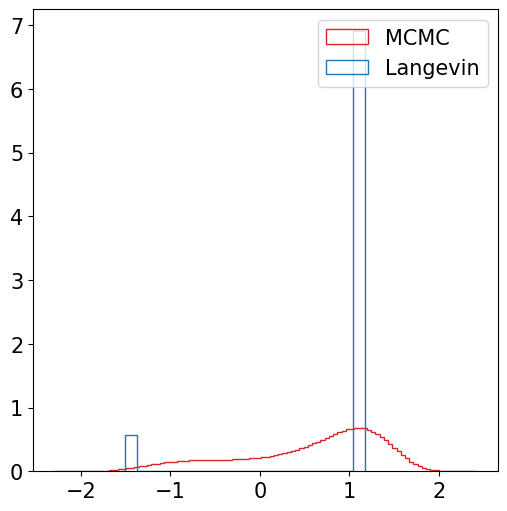

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /Users/huang/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


PyObject <matplotlib.legend.Legend object at 0x196f9dc40>

In [7]:
using Random, Distributions


function empirical_Gaussian(xs)
    N_ens, d = size(xs)
    mean = sum(xs, dims=1)/N_ens
    cov = 1/(N_ens - 1) * (xs - ones(N_ens)*mean')' * (xs - ones(N_ens)*mean')
    
    return mean, cov
    
end

function Langevin_update(xs, Ny, s_param, forward_derivative, x_obs, Σ_ν)
    N_ens, d = size(xs)
    
    # gradient step
    fs = zeros(N_ens, Ny)
    dfs = zeros(N_ens, Ny, d)
    
    for i = 1:N_ens
        fs[i, :], dfs[i, :, :] = forward_derivative(s_param, xs[i, :])
    end
    
    
    # Construct At
    # step two update
    # P1, Gaussian
    m , C = empirical_Gaussian(xs)
    
    At = zeros(N_ens, d, d)
    for i = 1:N_ens
        At[i, :, :] =  inv(inv(C) + dfs[i, :, :]'*(Σ_ν\dfs[i, :, :]))
    end
    
    # drift field
    F = copy(xs)
    for i = 1:N_ens
        F[i, :] =  At[i, :, :] * (dfs[i, :, :]'*(Σ_ν\(x_obs - fs[i, :])))
    end
    
    Δt = 1.0
    # step one update
    xs_step1 = xs + Δt*F
    
    # step two update
    # P1, Gaussian
    m , C = empirical_Gaussian(xs)
    
    xs_step2 = copy(xs_step1)
    for i = 1:N_ens
        xs_step2[i, :] +=  Δt*At[i, :, :] * (C\(xs[i, :] - m))
    end
    
#     @info "xs_step1, xs_step2 = ", xs_step1, xs_step2
    return xs_step1, xs_step2
    
end


function Langevin_Plot(forward, forward_aug, forward_aug_derivative; 
                       θ_ref = 1.0, σ_η = 1.0, μ_0 = 3.0,  σ_0 = 2.0) 
    
    s_param = Setup_Param(1, 1)
    y = forward(s_param, [θ_ref;])
    Σ_η = reshape([σ_η^2], (1, 1))
    
    Ny = 2
    x_obs, Σ_ν = [y; μ_0], [σ_η^2 0.0; 0.0 σ_0^2]
    
    d = 1
    N_ens = 1000
    xs = rand(Normal(μ_0, σ_0), N_ens, d)
    N_iter = 10
    for i = 1:N_iter
        xs_step1, xs = Langevin_update(xs, Ny, s_param, forward_aug_derivative, x_obs, Σ_ν)
    end
    
    
    # prior distribution
    μ0,  Σ0   = [μ_0;], reshape([σ_0^2],  (d, d))
    # compute posterior distribution by MCMC
    logρ(θ) = log_bayesian_posterior(s_param, θ, forward, y, Σ_η, μ0, Σ0) 
    step_length = 1.0
    N_iter , n_burn_in= 5000000, 1000000
    us = RWMCMC_Run(logρ, μ0, step_length, N_iter)
    
    
    nrows, ncols = 1, 1
    fig, ax = PyPlot.subplots(nrows=nrows, ncols=ncols, sharex=true, sharey=true, figsize=(6,6))
    
    
    ax.hist(us[n_burn_in:end, 1], bins = 100, density = true, histtype = "step", label="MCMC", color="C3")
    ax.hist(xs, bins = 20, density = true, histtype = "step", label="Langevin", color="C0")
    ax.legend()
end

Langevin_Plot(p2, p2_aug, p2_aug_derivative; θ_ref = 1.0, σ_η = 1.0, μ_0 = 3.0,  σ_0 = 2.0) 

In [37]:
# SVGD


using Statistics
using LinearAlgebra
using Distributions
using Random






# Stein variational gradient descent 
function SVGD_Kernel(θ; h = -1)
    J, nd = size(θ)

    XY = θ*θ';
    x2= sum(θ.^2, dims=2);
    X2e = repeat(x2, 1, J);
    pairwise_dists = X2e + X2e' - 2*XY

    if h < 0
        h = median(pairwise_dists)  
        h = sqrt(0.5 * h / log(J+1))
    end
    # compute the rbf kernel
    Kxy = exp.( -pairwise_dists / h^2 / 2)

    dxkxy = -Kxy * θ
    sumkxy = sum(Kxy, dims=2)
    for i = 1:nd
        dxkxy[:, i] = dxkxy[:,i] + θ[:,i].*sumkxy
    end

    dxkxy = dxkxy / (h^2)
    return Kxy, dxkxy
end

# lnprob(θ) = ∇ log p(θ)
# θs0 is a J by n_dim matrix
function SVGD_Run(θs0, s_param, forward_derivative, x_obs, Σ_ν, n_ite::IT = 1000; stepsize::FT = 1e-3, alpha = 0.9) where {FT<:AbstractFloat, IT<:Int}
        # Check input
    
    θs = copy(θs0) 
    lnpgrad = similar(θs0)
    J, nd = size(θs0)
    # adagrad with momentum
    fudge_factor = 1e-6
    historical_grad = 0
    
    for iter = 1:n_ite
        for i = 1:J
            f, df = forward_derivative(s_param, θs[i, :]) 
            lnpgrad[i, :] .= df'*(Σ_ν\(x_obs - f))
        end
        
#         @info "lnpgrad = ", lnpgrad
        
        # calculating the kernel matrix
        kxy, dxkxy = SVGD_Kernel(θs; h = -1)  
        grad_theta = (kxy * lnpgrad + dxkxy) / J  
        
        # adagrad 
        if iter == 1
            historical_grad = historical_grad .+ grad_theta .^ 2
        else
            historical_grad .= alpha * historical_grad .+ (1 - alpha) * (grad_theta .^ 2)
        end

        adj_grad = grad_theta ./ (fudge_factor .+ sqrt.(historical_grad))
        θs = θs + stepsize * adj_grad 
        
#         @info "iter : ", iter, " θs : ", θs
    end     

    return θs
end

SVGD_Run (generic function with 2 methods)

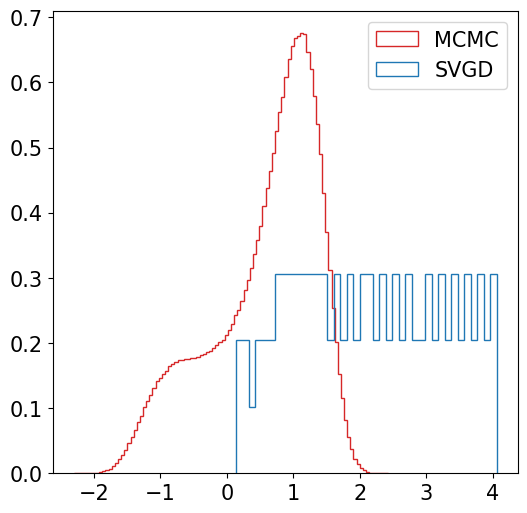

[1.0; 1.0404040404040404; 1.0808080808080809; 1.1212121212121213; 1.1616161616161615; 1.202020202020202; 1.2424242424242424; 1.2828282828282829; 1.3232323232323233; 1.3636363636363638; 1.404040404040404; 1.4444444444444444; 1.4848484848484849; 1.5252525252525253; 1.5656565656565657; 1.606060606060606; 1.6464646464646466; 1.6868686868686869; 1.7272727272727273; 1.7676767676767677; 1.8080808080808082; 1.8484848484848484; 1.8888888888888888; 1.9292929292929293; 1.9696969696969697; 2.0101010101010104; 2.0505050505050506; 2.090909090909091; 2.1313131313131315; 2.1717171717171717; 2.212121212121212; 2.2525252525252526; 2.2929292929292933; 2.333333333333333; 2.3737373737373737; 2.4141414141414144; 2.4545454545454546; 2.494949494949495; 2.5353535353535355; 2.5757575757575757; 2.6161616161616164; 2.6565656565656566; 2.696969696969697; 2.7373737373737375; 2.7777777777777777; 2.818181818181818; 2.8585858585858586; 2.898989898989899; 2.9393939393939394; 2.97979797979798; 3.0202020202020203; 3.0606

PyObject <matplotlib.legend.Legend object at 0x114d09520>

In [39]:
using Random, Distributions


function empirical_Gaussian(xs)
    N_ens, d = size(xs)
    mean = sum(xs, dims=1)/N_ens
    cov = 1/(N_ens - 1) * (xs - ones(N_ens)*mean')' * (xs - ones(N_ens)*mean')
    
    return mean, cov
    
end

#compute κ(xi, xj) and ∇_xj κ(xi, xj)
function kernel(xs, C)
    N_ens, d = size(xs)
    κ = zeros(N_ens, N_ens)
    dκ = zeros(N_ens, N_ens, d)
    invZ = 1.0/( (2π)^(d/2)*sqrt(det(C)) )
    
    for i = 1:N_ens
        for j = 1:N_ens
            dpower = C\(xs[i,:] - xs[j,:])
            power =  -0.5* ( (xs[i,:] - xs[j,:])' * dpower )  
            κ[i, j] = invZ * exp(power)
            dκ[i, j, :] = invZ * exp(power) * dpower
        end
    end
    
    return κ, dκ
end




function Affine_SVGD_update(xs, Ny, s_param, forward_derivative, x_obs, Σ_ν; Δt = 1.0, method = "derivative")
    N_ens, d = size(xs)
    
    # F gradient step
    fs = zeros(N_ens, Ny)
    dfs = zeros(N_ens, Ny, d)
    
    for i = 1:N_ens
        fs[i, :], dfs[i, :, :] = forward_derivative(s_param, xs[i, :])
    end
    
    # Φ gradient step
    Φs = zeros(N_ens)
    dΦs = zeros(N_ens, d)
    for i = 1:N_ens
        Φs[i]     = 0.5*(x_obs - fs[i, :])'*(Σ_ν\(x_obs - fs[i, :]))
        dΦs[i, :] = -dfs[i, :, :]'*(Σ_ν\(x_obs - fs[i, :]))
    end
    
    
    _, C = empirical_Gaussian(xs)
    κ, dκ = kernel(xs, C)
    
    # ∇θj[κ(θ, θj) C]
    F = copy(xs)
    for i = 1:N_ens
        F[i, :] =  1/N_ens* (C *  sum(dκ[i,:,:], dims = 1) )
    end
    
#     dρ = zeros(N_ens, d)
    dlogρ = zeros(N_ens, d)
        
        
    if method == "derivative"
        for i = 1:N_ens
            F[i, :] -=  1/N_ens * (C *  dΦs[:, :]'  * κ[i,:])
        end
    elseif method == "derivative-free"
        for i = 1:N_ens
            F[i, :] +=  1/N_ens * (C *  (Φs' * dκ[i,:,:]) )
        end
        
        for i = 1:N_ens
#             dρ[i, :] +=  1/N_ens * (sum(dκ[:,i,:], dims = 1))
            dlogρ[i, :] +=  sum(dκ[:,i,:], dims = 1)/sum(κ[:,i])
        end
            
        for i = 1:N_ens
            F[i, :] +=  1/N_ens * sum(C *  dlogρ' * (Φs .* κ[i,:]), dims = 2) 
        end
    
    end

    return xs + Δt*F
    
end


function Affine_SVGD_Plot(forward, forward_aug, forward_aug_derivative; 
                       θ_ref = 1.0, σ_η = 1.0, μ_0 = 3.0,  σ_0 = 2.0) 
    
    s_param = Setup_Param(1, 1)
    y = forward(s_param, [θ_ref;])
    Σ_η = reshape([σ_η^2], (1, 1))
    
    Ny = 2
    x_obs, Σ_ν = [y; μ_0], [σ_η^2 0.0; 0.0 σ_0^2]
    
    d = 1
    N_ens = 100
    
    xs0 = rand(Normal(μ_0, σ_0), N_ens, d)
    
    # for debugging
    xs0[:, 1] = LinRange(μ_0-σ_0, μ_0+σ_0, N_ens)
    print(xs0)
    
    
    N_iter = 100
    Δt = 0.01
    
    # Original SVGD
    xs_SVGD = SVGD_Run(xs0, s_param, forward_aug_derivative, x_obs, Σ_ν, N_iter; stepsize=Δt )
    
    
#     # Our Affine SVGD
#     method = "derivative"
#     xs_ASVGD = copy(xs0)
#     for i = 1:N_iter
#         xs_ASVGD = Affine_SVGD_update(xs_ASVGD, Ny, s_param, forward_aug_derivative, x_obs, Σ_ν; Δt = Δt, method = method )
#     end
    
    
#     # Our Affine SVGD
#     method = "derivative-free"
#     xs_DFASVGD = copy(xs0)
#     for i = 1:N_iter
#         xs_DFASVGD = Affine_SVGD_update(xs_DFASVGD, Ny, s_param, forward_aug_derivative, x_obs, Σ_ν; Δt = Δt, method = method )
#     end
    
    
    # prior distribution
    μ0,  Σ0   = [μ_0;], reshape([σ_0^2],  (d, d))
    # compute posterior distribution by MCMC
    logρ(θ) = log_bayesian_posterior(s_param, θ, forward, y, Σ_η, μ0, Σ0) 
    step_length = 1.0
    N_iter , n_burn_in= 5000000, 1000000
    us = RWMCMC_Run(logρ, μ0, step_length, N_iter)
    
    
    nrows, ncols = 1, 1
    fig, ax = PyPlot.subplots(nrows=nrows, ncols=ncols, sharex=true, sharey=true, figsize=(6,6))

    ax.hist(us[n_burn_in:end, 1], bins = 100, density = true, histtype = "step", label="MCMC", color="C3")
    ax.hist(xs_SVGD, bins = 40, density = true, histtype = "step", label="SVGD", color="C0")
#     ax.hist(xs_ASVGD, bins = 40, density = true, histtype = "step", label="Affine SVGD", color="C1")
#     ax.hist(xs_DFASVGD, bins = 40, density = true, histtype = "step", label="Derivative Free Affine SVGD", color="C2")
    ax.legend()
end

Affine_SVGD_Plot(p2, p2_aug, p2_aug_derivative; θ_ref = 1.0, σ_η = 1.0, μ_0 = 3.0,  σ_0 = 2.0) 

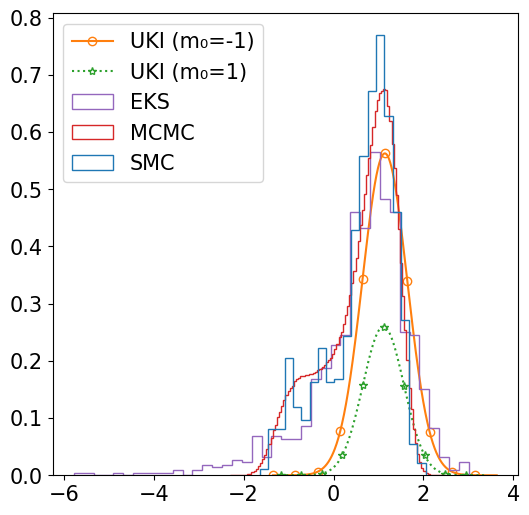

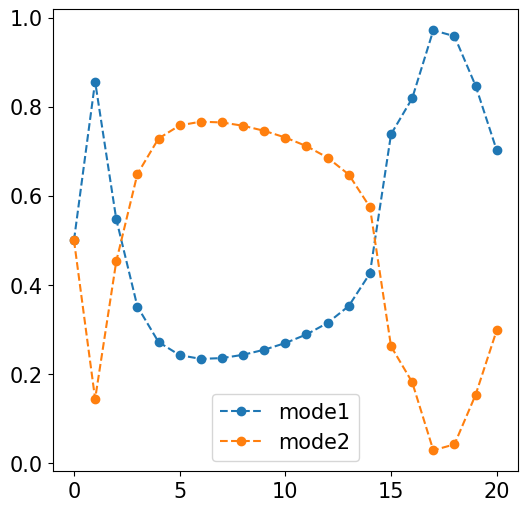

┌ Info: ("EKS large J t = ", 12.237118925808856)
└ @ Main In[143]:39
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:88
┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /Users/huang/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


PyObject <matplotlib.legend.Legend object at 0x1aadddf10>

In [146]:
Posterior_Plot(p2, p2_aug; θ_ref = 1.0, σ_η = 1.0, μ_0 = 3.0,  σ_0 = 2.0) 

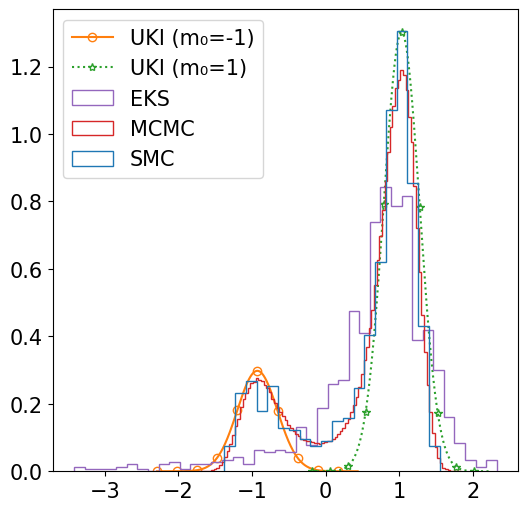

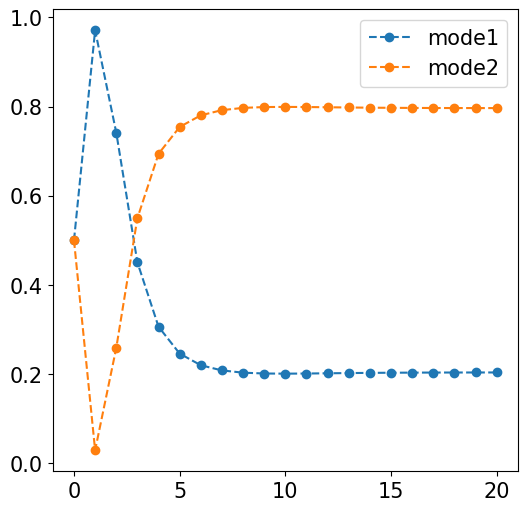

┌ Info: ("EKS large J t = ", 10.06277886708451)
└ @ Main In[143]:39
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:88


PyObject <matplotlib.legend.Legend object at 0x1b3058850>

In [147]:
Posterior_Plot(p2, p2_aug; θ_ref = 1.0, σ_η = 0.5, μ_0 = 3.0,  σ_0 = 2.0) 

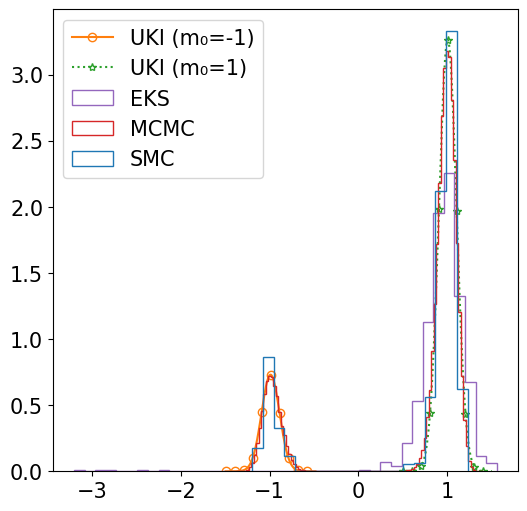

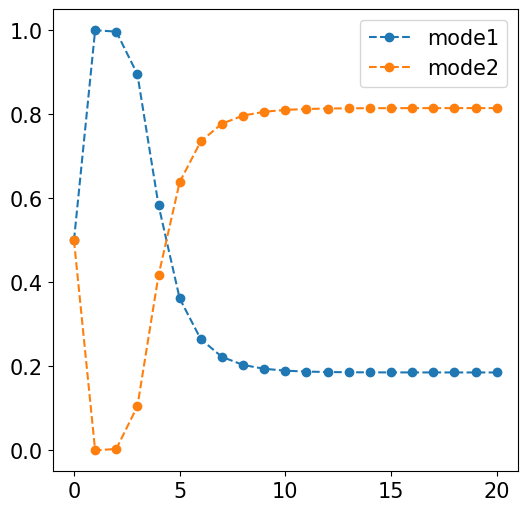

┌ Info: ("EKS large J t = ", 9.124247684031292)
└ @ Main In[143]:39
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:88


PyObject <matplotlib.legend.Legend object at 0x1b3162400>

In [148]:
Posterior_Plot(p2, p2_aug; θ_ref = 1.0, σ_η = 0.2, μ_0 = 3.0,  σ_0 = 2.0) 